this notebook is created by kevin zhu for SYDE 522.

references used:
- https://scikit-learn.org/stable/modules/clustering.html#k-means
- https://github.com/aihubprojects/Machine-Learning-From-Scratch/blob/master/K-Means%20from%20Scratch.ipynb
- https://muthu.co/mathematics-behind-k-mean-clustering-algorithm/

# K-means clustering

(from Wikipedia:)
>k-means clustering aims to partition $N$ observations into $K$ clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid)


<u> **KMeans algorithm** </u>

User specifies number of clusters $K$ to group data into.

a) initialize $K$ centroids.

b) assign each datapoint to the closest centroid. Compute WCSS based on these labels.

c) recompute centroids as the mean of all points belonging to that centroid.

Repeat steps (b-c) until WCSS convergences.



In [2]:
# import libraries used
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

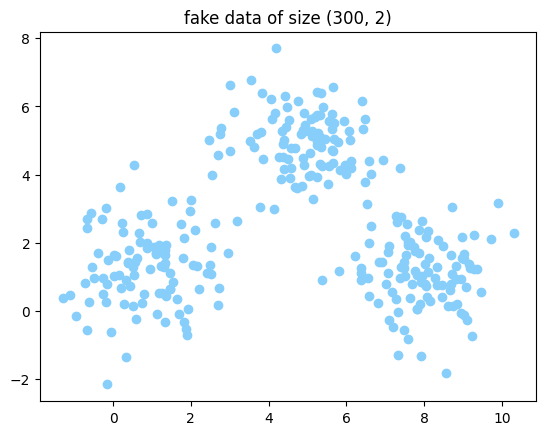

In [3]:
# Generate fake data (with 3 clusters)
center_1 = np.array([1, 1])
center_2 = np.array([5, 5])
center_3 = np.array([8, 1])

np.random.seed(711)
cluster_1 = np.random.randn(100, 2) + center_1
cluster_2 = np.random.randn(100, 2) + center_2
cluster_3 = np.random.randn(100, 2) + center_3
data = np.concatenate((cluster_1, cluster_2, cluster_3), axis=0)

# -----------------------------------------------------------------------------
# plot
plt.scatter(data[:, 0], data[:, 1], c="lightskyblue")
plt.title("fake data of size {}".format(data.shape))
plt.show()

### 1. KMeans from scratch (kind of)

#### 1a) Initialize K random centroids.

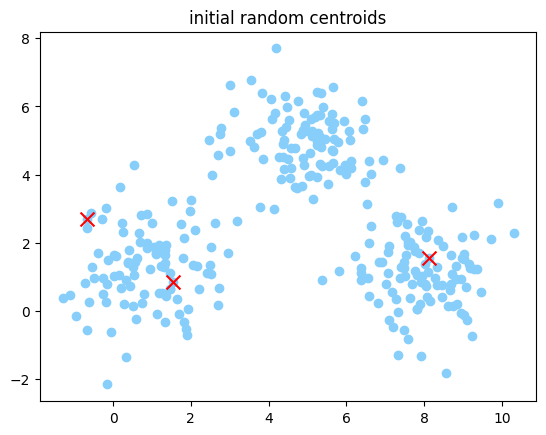

In [4]:
# randomly initialize K=3 centroids
K = 3

np.random.seed(711)
centroids = data[
    np.random.randint(0, data.shape[0], K)
]  # randomly pick K points in dataset as centroids

# -----------------------------------------------------------------------------
# plot
plt.scatter(data[:, 0], data[:, 1], c="lightskyblue")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker="x", s=100)
plt.title("initial random centroids")
plt.show()

#### 1b) Assign observations to closest centroid

First, let's compute the distance between each data observation and each centroid. We can use sum of squares $SS$ (or Euclidian distance squared) as our distance metric:

For any two $M$-dimension vectors $U = [u_1,..., u_M]$ and $V = [v_1,..., v_M]$:
$$
SS(U,V) = ||U - V||^2_2 = \sum_{i=1}^{M} (u_i - v_i)^2
$$

Let's store all of these distances in a $N$ x $K$ matrix $M_{SS}$ where row $n$ and column $k$ corresponds to the distance between the $n$-th observation and $k$-th centroid.

In [9]:
""" 
Compute sum of squares (SS), or Euclidian distance squared, between each data observation and each centroid.

Args:
    data (NxM): dataset of M-dimensions with N observations.
    centroids (KxM): K centroids of dimension M.

Returns:
    SS_matrix (NxK): matrix storing squared distances between each observation and each centroid.
"""


def compute_distance_matrix(data, centroids):
    N = len(data)
    K = len(centroids)

    # compute sum of squares between each point and each centroid
    # your code here.
    SS_matrix = np.zeros((N, K))
    for k in range(K):
        SS_matrix[:, k] = np.sum((data - centroids[k]) ** 2, axis=1)
    
    # SS_matrix = np.random.rand(N, K)  # delete this

    return SS_matrix

In [12]:
centroids

array([[-0.66580076,  2.71383664],
       [ 1.53621498,  0.86191101],
       [ 8.11913112,  1.57013849]])

In [14]:
ss_matrix = compute_distance_matrix(data, centroids)
ss_matrix[:3]

array([[14.12974794,  2.70456594, 26.70502587],
       [ 3.91302711,  2.90520637, 69.25556751],
       [10.1766626 ,  2.08673557, 60.02719425]])

Next we assign each observation to the closet centroid.

- *i.e.* from our distance matrix $M_{SS}$ we take the index of the column corresponding to the smallest value as the label for the observation)

Based on the current labeling (assignment of data observations to centroids), compute the total within-cluster sum of squares $WCSS$:
$$
\text{total}\;\; WCSS = \sum_k \sum_{i\in C_k} SS(x_i,\; \text{centroid}_k) 
\quad \text{or} \quad 
\sum_k \sum_{\text{label}(x_i)=k} SS(x_i,\; \text{centroid}_k) 
$$
- for each $\text{centroid}_k$, take the sum of the distances between $\text{centroid}_k$ and all datapoints $x_i$ that belong to $\text{centroid}_k$ (closest to $\text{centroid}_k$). Then sum over all $K$ centroids.

In [15]:
""" 
Assign each datapoint to the closest centroid based on a distance matrix. 
Compute the total WCSS for the corresponding labels. 

Args:
    SS_matrix (NxK): matrix storing squared distances between each observation and each centroid.

Returns:
    labels (N-sized vector): N labels that assign each data point to a centroid.
    WCSS: total WCSS based on current labeling scheme.
"""


import numpy as np


def assign_centroid(SS_matrix):
    N, K = SS_matrix.shape

    # Assign each point to the closest centroid
    labels = np.argmin(SS_matrix, axis=1)

    # Compute the total within-cluster sum of squares (WCSS)
    WCSS = 0.0
    for k in range(K):
        # Get the indices of data points assigned to cluster k
        cluster_indices = np.where(labels == k)[0]
        # Calculate the sum of squared distances within the cluster
        cluster_sum = np.sum(SS_matrix[cluster_indices, k])
        WCSS += cluster_sum

    return labels, WCSS

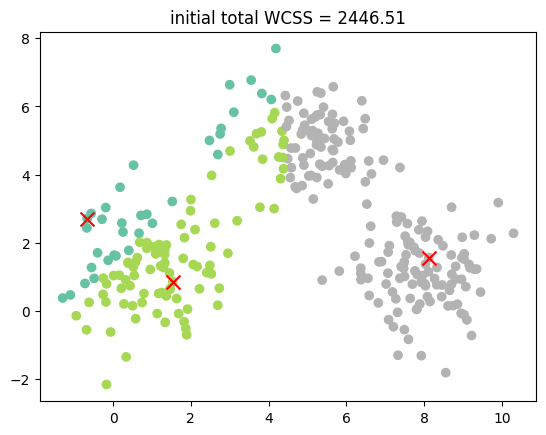

In [16]:
# step 1b
SS_matrix = compute_distance_matrix(data, centroids)
labels, WCSS = assign_centroid(SS_matrix)

# -----------------------------------------------------------------------------
# plot
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="Set2")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker="x", s=100)
plt.title("initial total WCSS = {:.2f}".format(WCSS))
plt.show()

#### 1c) Update centroids.

We take the mean of each newly formed cluster (datapoints with the same label), as the updated centroid.

In [ ]:
""" 
Update centroids as the mean of each cluster.

Args:
    data (NxM): dataset of M-dimensions with N observations.
    labels (N-sized vector): N labels that assign each data point to a centroid.
    K (int): number of clusters.

Returns:
    centroids (KxM): K centroids of dimension M.
"""

def update_centroids(data, labels, K):
    N, M = data.shape
    centroids = np.zeros((K, M))

    for k in range(K):
        # Find the indices of data points that belong to cluster k
        cluster_indices = np.where(labels == k)[0]

        # Calculate the mean of data points in cluster k
        if len(cluster_indices) > 0:
            cluster_mean = np.mean(data[cluster_indices, :], axis=0)
            centroids[k, :] = cluster_mean
        else:
            # If there are no data points in the cluster, keep the centroid unchanged
            centroids[k, :] = data[np.random.choice(N), :]

    return centroids


In [ ]:
# step 1c
newcentroids = update_centroids(data, labels, K=3)

#-----------------------------------------------------------------------------
# plot
plt.scatter(data[:,0],data[:,1], c=labels, cmap='Set2')
plt.scatter(centroids[:,0],centroids[:,1], c = 'red', marker = 'x', s = 100, label = 'previous')
plt.scatter(newcentroids[:,0],newcentroids[:,1], c = 'fuchsia', marker = '^', s = 100, label = 'new')
plt.legend()
plt.title('initial total WCSS = {:.2f}'.format(WCSS))
plt.show()

#### Repeat steps 1b and 1c...

In [ ]:
# repeat 1b
SS_matrix = compute_distance_matrix(data, newcentroids)
labels, WCSS = assign_centroid(SS_matrix)
# repeat 1c
newcentroids2 = update_centroids(data, labels, K=3)

#-----------------------------------------------------------------------------
# plot
plt.scatter(data[:,0],data[:,1], c=labels, cmap='Set2')
plt.scatter(newcentroids[:,0],newcentroids[:,1], c = 'red', marker = 'x', s = 100, label = 'old')
plt.scatter(newcentroids2[:,0],newcentroids2[:,1], c = 'fuchsia', marker = '^', s = 100, label = 'new')
plt.legend()
plt.title('new total WCSS = {:.2f}'.format(WCSS))
plt.show()

#### Repeat steps 1b-c 9 times...

In [ ]:
plt.figure(9,figsize = (12,12))

#initial
SS_matrix = compute_distance_matrix(data, centroids)
labels, WCSS = assign_centroid(SS_matrix)

# iterate J=9 times:
J = 9
wcss_list = [WCSS] #track wcss over iterations

for j in range(J):
    newcentroids = update_centroids(data, labels, K=3)
    SS_matrix = compute_distance_matrix(data, newcentroids)
    labels, WCSS = assign_centroid(SS_matrix)

    ax = plt.subplot(331 + j)
    plt.scatter(data[:,0],data[:,1], c=labels, cmap='Set2')
    plt.scatter(centroids[:,0],centroids[:,1], c = 'red', marker = 'x', s = 100, label = 'prev')
    plt.scatter(newcentroids[:,0],newcentroids[:,1], c = 'fuchsia', marker = '^', s = 100, label = 'new')
    plt.title('(after {} it.) new WCSS = {:.2f}'.format(j+1, WCSS))
    plt.legend()

    wcss_list.append(WCSS)
    centroids = newcentroids #update previous to new

plt.show()

how do we determine how many iterations to repeat?


#### 1d) Stopping threshrold

- when WCSS stops improving,
- or when centroids stop moving.

In [ ]:
# plot wcss over iterations

plt.figure(figsize = (4,3))
plt.plot(wcss_list)
plt.title('Total WCSS over iterations')
plt.show()

#### Putting it together...

In [ ]:
def myKMeans(data, K=3, threshold = 0.01, max_iterations = 500, random_state = 711):
        
    # step a: initialize centroids
    np.random.seed(random_state)
    centroids = data[np.random.randint(0, data.shape[0], K)]

    prevWCSS = 0
    # repeat steps b and c
    for j in range(max_iterations):    
        
        # step b: assign labels
        SS_matrix = compute_distance_matrix(data, centroids)
        labels, WCSS = assign_centroid(SS_matrix)

        # check stopping
        improvement = prevWCSS - WCSS
        if improvement < threshold and j>0:
            #print('myKMeans stopped after {} iterations.'.format(j+1))
            return labels, WCSS

        # step c: update centroids
        centroids = update_centroids(data, labels, K)
        prevWCSS = WCSS

    return labels, WCSS

### 2. Comparing to Sklearn

In [ ]:
from sklearn.cluster import KMeans

K = 3

# sklearn implementaion of kmeans
kmeans_sklearn = KMeans(n_clusters=K, random_state = 711)
kmeans_sklearn.fit(data) #fit kmeans to data
labels_sklearn = kmeans_sklearn.labels_

# our implementation:
labels_ours, wcss_ours = myKMeans(data, K)

#-----------------------------------------------------------------------------
# plot
plt.figure(2,figsize = (11,4))
ax = plt.subplot(121)
plt.scatter(data[:,0],data[:,1], c=labels_sklearn, cmap='Set2')
plt.title('KMeans using sklearn')

ax = plt.subplot(122)
plt.scatter(data[:,0],data[:,1], c=labels_ours, cmap='Set2')
plt.title('clustering using myKMeans')
plt.show()

### 3. How to select K?

Elbow method:

In [ ]:
wcss_all = []
krange = range(1,10) # compute wcss for different K = 1,...,9

for k in krange:
    labels_k, wcss_k = myKMeans(data, K=k)
    wcss_all.append(wcss_k)

#-----------------------------------------------------------------------------
# plot
plt.figure(figsize = (4,3))
plt.plot(krange, wcss_all)
plt.title('Elbow method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Total WCSS')
plt.xticks(np.arange(1,10,2))
plt.show()

### 4. When does KMeans fail?


#### Poor initial centroids:

(source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html)

In [ ]:
# when does kmeans fail?

from sklearn.datasets import make_blobs

# generate unevenly sized blobs
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_filtered = np.vstack(
    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
)  # Unevenly sized blobs
y_filtered = [1] * 500 + [2] * 100 + [0] * 10


# our kmeans:
K = 3
#random state = 100
labels, wcss = myKMeans(X_filtered, K, random_state = 100)
np.random.seed(100)
centroids = X_filtered[np.random.randint(0, X_filtered.shape[0], K)] #initial centroid
newcentroids = update_centroids(X_filtered, labels, K) #final centroid

#random state = 101
labels2, wcss2 = myKMeans(X_filtered, K, random_state = 101)
np.random.seed(101)
centroids2 = X_filtered[np.random.randint(0, X_filtered.shape[0], K)] #initial centroid
newcentroids2 = update_centroids(X_filtered, labels2, K) #final centroid

#-----------------------------------------------------------------------------
# plot
plt.figure(3,figsize = (12,4))
ax = plt.subplot(131)
ax.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered)
ax.set_title("True labels")

ax = plt.subplot(132)
ax.scatter(X_filtered[:, 0], X_filtered[:, 1], c=labels)
plt.scatter(centroids[:,0],centroids[:,1], c = 'red', marker = 'x', s = 100, label = 'initial')
plt.scatter(newcentroids[:,0],newcentroids[:,1], c = 'fuchsia', marker = '^', s = 100, label = 'final')
plt.legend()
ax.set_title("myKMeans w/ initial state = 100, \n total WCSS={:.2f}".format(wcss))

ax = plt.subplot(133)
ax.scatter(X_filtered[:, 0], X_filtered[:, 1], c=labels2)
plt.scatter(centroids2[:,0],centroids2[:,1], c = 'red', marker = 'x', s = 100, label = 'initial')
plt.scatter(newcentroids2[:,0],newcentroids2[:,1], c = 'fuchsia', marker = '^', s = 100, label = 'final')
plt.legend()
ax.set_title("myKMeans w/ initial state = 101, \n total WCSS={:.2f}".format(wcss2))

plt.show()

#### Other data distributions:

(source: https://scikit-learn.org/stable/modules/clustering.html)

![](clustering.png)

can we still apply KMeans to all rows above?